### Постановка задачи
Исследовать некоторые свойства представления кода с помощью модели ```code2vec```. А именно ответить на вопросы:

* Будут ли близкими вектора, соответствующие семантически близким фрагментам кода?
* Какую меру близости лучше всего использовать?

Для проведения исследования решил взять уже обученную модель из [репозитория](https://github.com/tech-srl/code2vec), из коробки она работает только с кодом на ```Java```.

Под семантикой я понимаю смысл который заложен в код, задачу которую он решает. Например, существует много принципиально разных подходов к сортировке (с идейной и синтаксической точки зрения), но семантически это одно и тоже. Для синтаксического сравнения кажется достатчно посмотреть на ```AST``` деревья. Для семантики этого недостаточно. И все же если на вход подаются два семантически одинаковых куска кода, то хочется чтобы их представления были похожи. Под представлением понимается вектор в многомерном пространстве.

Что значит похожесть? Наверно можно сказать, что это пространственная близость векторов. Например, косинусное расстояние.

<img src="images/metrics.jpg" alt="alt text" width="800"/>

Какую меру близости взять? На картинке видно, что метрика Миньковского, Евклидово и Манхэттенское расстояние завязаны на длины векторов, грубо говоря чем меньше расстояние по линейке тем лучше. А косинусное расстояние учитывает только угол, т.е вектора могут находиться далеко друг от друга, но при этом быть близкими. 

То есть косинусное расстояние учитывает масштаб векторов, например, если взять два тематически одинаковых текста разной длины, то косинусное расстояние покажет на близость, в то время как евклидово расстояние выберет иной текст соизмеримого масштаба, и он может быть совсем на другую тему. Но это не значит что евклидово расстояние нельзя использовать. Просто важно не забывать нормализовывать вектора. При нормализации косинус не изменится, а евклидово расстояние перестанет зависеть от масштабов. Таким образом обе меры имеют право на жизнь.

Примеры для описанной выше ситуации с масштабами хорошо подобраны [здесь](https://cmry.github.io/notes/euclidean-v-cosine)

### Идея решения
Определим набор из $K$ несложных задач. Если задача имеет несколько решений, то все они определяют ее однозначно, и эти решения должны быть семантически похожи. При этом они могут отличаться синтаксически.

Давайте попробуем решить задачу классификации для представлений, которые выдаст модель ```code2vec```. Если качество решения будет высоким, то появятся основания утверждать, что вектора, соответствующие семантически близким фрагментам кода, будут близкими.

Сделаем классификацию для трех классов $K = 3$, чтобы понизить вероятность случайности. Будем решать задачи:

* Вычисление факториала. Рекурсивно, циклом, через стримы.
* Сортировка массива. Пузырьковая, слиянием, вставками.
* Бинарный поиск. Рекурсивно, циклом, библиотечной функцией.

Для каждой задачи есть несколько шаблонов решения на ```Java```. Они находятся в директории ```code_patterns```. Все шаблоны параметризированы так, чтобы можно было менять имя и возвращаемый тип функции, имена и типы аругуметов, а также добавить немного шума в виде бесполезных строчек кода. Вся эта логика реализована в классе ```CodeFormatter```, который случайным образом подставляет значения в параметры.

Итого, для каждой задачи случайым образом сформируем одинаковое количество идейно/синтаксически разных фрагментов кода и положим в ```code_snippets```, каждый сниппет подадим на вход модели, а полученные эмбеддинги сохраним в ```vectors.json```

In [2]:
import code_patterns.factorial_patterns as fp
import code_patterns.binsearch_patterns as bp
import code_patterns.sort_patterns as sp
from code_formatter import CodeFormatter

from random import choice
from json import dump, load

Как это будет выглядеть, например, в ```fp``` лежат принципиально разные шаблоны для вычисления факториала. Возьмем один из них

In [150]:
print(fp.LOOP_FACTORIAL)

{return_type} {function_name}({argument_type} {argument_name}) {{
    {useless_statement_0}
    {return_type} {result_name} = 1;
    {useless_statement_1}
    for (int i = 1; i <= {argument_name}; i++) {{
        {useless_statement_2}
        {result_name} = {result_name} * i;
    }}
    {useless_statement_3}
    return {result_name};
}}


Теперь форматируем его (эта операция не является идемпотентной)

In [152]:
print(CodeFormatter().format(fp.LOOP_FACTORIAL))

int f(int a) {
    int variable_ = 45 + 96;
    int r = 1;
    string greet_ = "hello world";
    for (int i = 1; i <= a; i++) {
        
        r = r * i;
    }
    boolean b1_ = Boolean.parseBoolean("true");
    return r;
}


Теперь получим ```SAMPLES_COUNT``` таких сниппетов для каждой задачи и запишем в ```code_snippets/snippets.json```.

In [165]:
SAMPLES_COUNT = 25
SNIPPETS_DIR = "code_snippets"

cf = CodeFormatter()

factorial_snippets = dict()
binsearch_snippets = dict()
sort_snippets = dict()

for i in range(SAMPLES_COUNT):
    factorial_snippets[i] = cf.format(choice(fp.ALL))
    binsearch_snippets[i] = cf.format(choice(bp.ALL))
    sort_snippets[i] = cf.format(choice(sp.ALL))

with open(f"{SNIPPETS_DIR}/snippets.json", "w") as file:
    dump({
        "factorial_snippets": factorial_snippets, 
        "binsearch_snippets": binsearch_snippets,
        "sort_snippets": sort_snippets
        }, 
        file
    )

Далее эти сниппеты на виртуальной машине преобразуются в эмбеддинги, которые я вычислил в облаке и руками подгрузил файл ```vectors.json```. Все дело в том, что локально оперативной памяти не хватает, а на виртуалке неудобно работать с ноутбуком. В конце будет небольшая инструкция.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
with open("vectors.json", "r") as file:
    vectors = load(file)

In [5]:
def get_vectors(name: str) -> np.array:
    return np.array([
        np.array(list(map(float, v.split())))
        for index, v in vectors.get(name, {}).items()
    ])
    
factorial_vectors = get_vectors("factorial_vectors")
binsearch_vectors = get_vectors("binsearch_vectors")
sort_vectors = get_vectors("sort_vectors")

In [6]:
factorial_vectors.shape, binsearch_vectors.shape, sort_vectors.shape

((25, 384), (25, 384), (25, 384))

Видно что размер эмбеддинга равняется $384$. Его можно поменять в настройках модели.

In [7]:
fdf = pd.DataFrame(data = factorial_vectors)
fdf["label"] = 0

bdf = pd.DataFrame(data = binsearch_vectors)
bdf["label"] = 1

sdf = pd.DataFrame(data = sort_vectors)
sdf["label"] = 2

df = pd.concat([fdf, bdf, sdf]).sample(frac = 1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,label
24,-0.284186,-0.316161,0.080168,-0.442066,-0.125714,-0.477422,0.226211,0.488984,-0.246327,-0.100648,...,-0.211125,0.132041,0.476380,-0.252866,-0.286592,0.607291,-0.352215,-0.118240,-0.135070,0
10,0.081493,-0.651112,-0.638130,0.442133,0.537002,-0.270460,0.338716,0.133654,-0.846908,-0.351121,...,-0.801800,0.083339,0.173436,-0.112406,-0.384369,0.619718,0.569659,-0.158762,-0.221877,2
8,-0.213305,-0.431759,0.136044,-0.405652,-0.521524,-0.707465,0.345575,0.197854,0.347300,-0.079520,...,0.460335,-0.105363,0.576506,-0.496164,-0.002336,0.366323,0.368262,0.433860,-0.653981,2
4,0.679117,-0.741972,-0.073988,-0.328330,0.638518,-0.460225,-0.346784,0.006724,0.546102,0.021278,...,-0.691283,0.415386,-0.147589,0.122115,0.207878,-0.001447,0.612698,-0.749560,-0.841889,1
14,0.805895,0.747808,-0.771925,0.572001,-0.808863,0.666763,0.688268,0.860574,0.644411,0.714973,...,-0.758987,-0.739233,0.714818,-0.203594,0.765296,0.739038,-0.793448,0.519704,0.676928,2


In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [206]:
clf = KNeighborsClassifier(
    n_neighbors = 5,
    metric = "cosine"
)

In [202]:
X = df.drop(["label"], axis = 1).values
y = df["label"].values

In [208]:
X.shape, y.shape

((75, 384), (75,))

In [209]:
from sklearn.metrics import accuracy_score, classification_report

clf = clf.fit(X, y)
y_pred = clf.predict(X)

accuracy_score(y, y_pred)

0.9733333333333334

In [210]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        25
           1       1.00      1.00      1.00        25
           2       0.96      0.96      0.96        25

    accuracy                           0.97        75
   macro avg       0.97      0.97      0.97        75
weighted avg       0.97      0.97      0.97        75



Поскольку нашлась гиперплоскость, которая уверенно разделяет эмбеддинги трех классов за счет косинусного расстояния, **можно утверждать что модель ```code2vec``` действительно может отражать семантические сходства**.

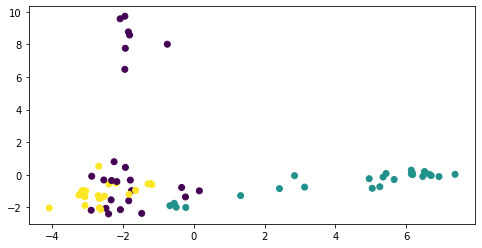

In [215]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2'])
df['y'] = y

fig, ax = plt.subplots(figsize = (8, 4))
ax.scatter(df.PC1, df.PC2, c = df.y)

plt.show()

Поскольку нормализации не было, евклидово расстояние здесь при большем количестве экземпляров либо при большем парметре ```n_neighbors``` дало бы результат хуже по сравнению с косинусной мерой. Ну действительно:

In [217]:
clf = KNeighborsClassifier(
    n_neighbors = 10,
#     metric = "cosine"
)

clf = clf.fit(X, y)
y_pred = clf.predict(X)

accuracy_score(y, y_pred)

0.9066666666666666

Поэтому если использовать евклидово расстояние, то важно не забыть нормализовать

In [224]:
from sklearn.preprocessing import normalize

X_norm = normalize(X)
clf = clf.fit(X_norm, y)
y_pred = clf.predict(X)

accuracy_score(y, y_pred)

0.96

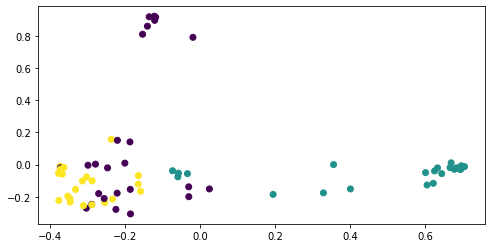

In [225]:
df_norm = pd.DataFrame(pca.fit_transform(X_norm), columns=['PC1', 'PC2'])
df_norm['y'] = y

fig, ax = plt.subplots(figsize = (8, 4))
ax.scatter(df_norm.PC1, df_norm.PC2, c = df_norm.y)

plt.show()

### Небольшая инструкция о том как получать эмбеддинги с помощью ```code2vec```.

In [1]:
! git clone https://github.com/tech-srl/code2vec

Cloning into 'code2vec'...
remote: Enumerating objects: 703, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 703 (delta 0), reused 0 (delta 0), pack-reused 698
Receiving objects: 100% (703/703), 5.14 MiB | 4.53 MiB/s, done.
Resolving deltas: 100% (412/412), done.


Шаг с загрузкой/подготовкой датасета пропускаем. Вместо этого загрузим и распакуем уже обученную модель

In [4]:
! wget https://s3.amazonaws.com/code2vec/model/java14m_model.tar.gz; tar -xvzf java14m_model.tar.gz

--2022-11-16 17:07:40--  https://s3.amazonaws.com/code2vec/model/java14m_model.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.232.200
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.232.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1440921240 (1,3G) [application/x-tar]
Saving to: ‘java14m_model.tar.gz’

java14m_model.tar.g 100%[===================>]   1,34G  3,83MB/s    in 11m 25s 

2022-11-16 17:19:06 (2,01 MB/s) - ‘java14m_model.tar.gz’ saved [1440921240/1440921240]

models/java14_model/saved_model_iter8.release.data-00000-of-00001
models/java14_model/saved_model_iter8.release.index
models/java14_model/saved_model_iter8.release.meta
models/java14_model/dictionaries.bin


На вход модель принимает данные из файла ```Input.java```

In [13]:
! cat code2vec/Input.java







}

Ниже видно что у меня нехватка памяти, поэтому этот шаг я сделал в облаке. И еще, пришлось немного модифицировать файл проекта ```interactive_predict.py``` с предсказаниями, чтобы автоматизировать большой объем работы, по дефолту можно получать по одному вектору за раз. Новый файл я положил в ```code2vec```, и если вдруг захочется воспроизвести получение эмбеддингов, то все что нужно сделать это подключиться в облако и проделать шаги выше, предварительно заменив файл. И еще если в на виртуалке не стоит компилятор ```Java```, то [вот](https://www.digitalocean.com/community/tutorials/how-to-install-java-with-apt-on-ubuntu-20-04)

In [14]:
! python3 code2vec/code2vec.py --load code2vec/models/java14_model/saved_model_iter8.release --predict --export_code_vectors

2022-11-16 17:26:19.573964: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 17:26:19,575 INFO     
2022-11-16 17:26:19,575 INFO     
2022-11-16 17:26:19,575 INFO     ---------------------------------------------------------------------
2022-11-16 17:26:19,575 INFO     ---------------------------------------------------------------------
2022-11-16 17:26:19,575 INFO     ---------------------- Creating code2vec model ----------------------
2022-11-16 17:26:19,575 INFO     ---------------------------------------------------------------------
2022-11-16 17:26:19,575 INFO     ---------------------------------------------------------------------
2022-11-16 17:26:19,575 INFO     Checking number of examples ...
